# Model creation (alternative)

Use this notebook to create a model using a specific method, but with data coming from the alternative calibration method

- [Polynomial regression](#polynomial-regression)

# Setup

In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

import common_functions as cf

import importlib

importlib.reload(cf)

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
NR_SUBREGIONS = 3
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
NAME_PREFIX = lambda i: f"H1_5-s{i}-20231218-005"
MODEL_NAME_Z = "table_calibration/2x2_grid_subsampling_x3_08032024_schroef2"
MODEL_NAME_XY = "table_calibration/2x2_grid_xy_subsampling_x3_08032024_schroef2"

# Splitting the dataset
## Converting to DF and splitting

In [2]:
importlib.reload(cf)

data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

all_data = []

for i, name in enumerate([MODEL_NAME_Z, MODEL_NAME_XY]):
    TFdata = cf.read_csv_file(f"../data/raw/TF/{name}.csv") 
    sensordata = cf.read_csv_file(f'../data/raw/sensor/{name}.csv')
    
    # First unwrap the sensordata
    sensordata = cf.unwrap_data(sensordata, data_columns)

    # Time sync
    data = cf.time_sync_data(sensordata, TFdata, SENSOR_LAG / 1000)

    # Remove mean of first 100 samples
    data = cf.offset_data(data, data_columns, 100)

    # Remove rows containing NaN values
    data = data.dropna()
    
    # Remove other columns
    data = data.drop(columns=['t_robot', 'R_x', 'R_y', 'R_z'])

    all_data.append(data)
    
print("Data loaded")
all_data[0].info() # Z-calibration
all_data[1].info() # XY-calibration

Data loaded
<class 'pandas.core.frame.DataFrame'>
Int64Index: 59476 entries, 1 to 59476
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   59476 non-null  int64  
 1   t_wall  59476 non-null  float64
 2   X0      59476 non-null  float64
 3   Y0      59476 non-null  float64
 4   Z0      59476 non-null  float64
 5   X1      59476 non-null  float64
 6   Y1      59476 non-null  float64
 7   Z1      59476 non-null  float64
 8   X2      59476 non-null  float64
 9   Y2      59476 non-null  float64
 10  Z2      59476 non-null  float64
 11  X3      59476 non-null  float64
 12  Y3      59476 non-null  float64
 13  Z3      59476 non-null  float64
 14  F_x     59476 non-null  float64
 15  F_y     59476 non-null  float64
 16  F_z     59476 non-null  float64
 17  T_x     59476 non-null  float64
 18  T_y     59476 non-null  float64
 19  T_z     59476 non-null  float64
 20  X       59476 non-null  float64
 21  Y       59476 non-null 

(16, 2)


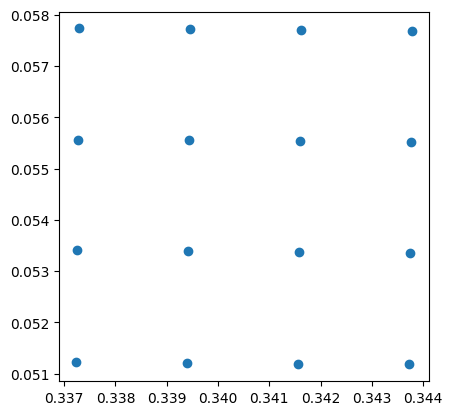

In [3]:
# Boundary search of where the x,y is valid
z_filter = all_data[0]['Z'].copy().to_numpy()
z_filter[all_data[0]['Z'] - np.min(z_filter) > 0.003] = 0
z_filter[z_filter.nonzero()] = 1
boundaries = np.diff(z_filter).nonzero()[0].reshape(-1, 2)

print(boundaries.shape)

# Now take the average of the boundaries, applied as a filter to X and Y
data_points = np.zeros((ARRAY_SIZE_SUB, 2))
assert boundaries.shape[0] == ARRAY_SIZE_SUB

for i in range(ARRAY_SIZE_SUB):
    data_points[i][0] = all_data[0]['X'].to_numpy()[boundaries[i][0]:boundaries[i][1]].mean()
    data_points[i][1] = all_data[0]['Y'].to_numpy()[boundaries[i][0]:boundaries[i][1]].mean()
    
plt.scatter(data_points[:,0], data_points[:,1])
plt.gca().set_aspect('equal', adjustable='box')

In [4]:
all_data_transformed = []
z_calibration_indices = []

# Transforming the data
for i in range(ARRAY_SIZE_SUB):
    
    Z_calibration = all_data[0]
    XY_calibration = all_data[1]
    
    z_calibration_indices.append(len(Z_calibration))
    
    # Concat them together    
    data = pd.concat([Z_calibration, XY_calibration], axis=0)

    all_data_transformed.append(data)

In [5]:
# Save taxel models (per taxel)
import dill

def save_taxel_models(taxel_models, subdir, name):
    
    while '/' in name:
        subdir = os.path.join(subdir, name.split('/')[0])
        name = name.split('/')[-1]
        
    save_path = os.path.join(os.getcwd(), '..', 'models', subdir)

    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    with open(os.path.join(save_path, name), 'wb') as f:
        dill.dump(taxel_models, f)
        

# Polynomial regression

Calibration achieved by pressing on all taxel one-by-one without silicone layer

In [6]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import PolynomialFeatures
from sklearn import set_config
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.compose import TransformedTargetRegressor

set_config(display='diagram')

COUPLE_COMPONENTS = True
POLY_DEGREE = 2

def create_regression_pipeline_and_fit(X, Y, debug = True, preserve_time=False, alpha=1.0):
  
  if preserve_time:
    split = int(len(X) * 0.9)
    X_train = X[:split]
    X_test = X[split:]
    y_train = Y[:split]
    y_test = Y[split:]
  else:
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)

  pipeline = make_pipeline(
    PolynomialFeatures(degree=POLY_DEGREE, include_bias=False), 
    # LinearRegression()
    Ridge(alpha=alpha)
  )
  
  pipeline.fit(X_train, y_train)

  if debug:
    
    print("Score: ", pipeline.score(X_test, y_test))
    print("MSE: ", mean_squared_error(y_test, pipeline.predict(X_test)))
  
  return pipeline

class CombinedModel:
  
  def __init__(self, component_models) -> None:
    self.component_models = component_models
    
  def predict(self, X):
    
    predictions = []
    
    for i, model in enumerate(self.component_models):
      predictions.append(model.predict(X[:, i].reshape(-1, 1))[:, 0])
    
    return np.array(predictions).T

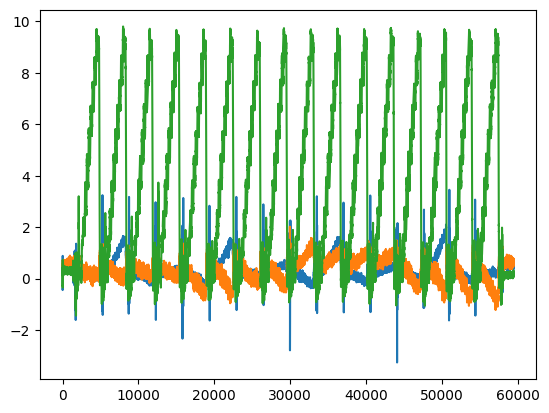

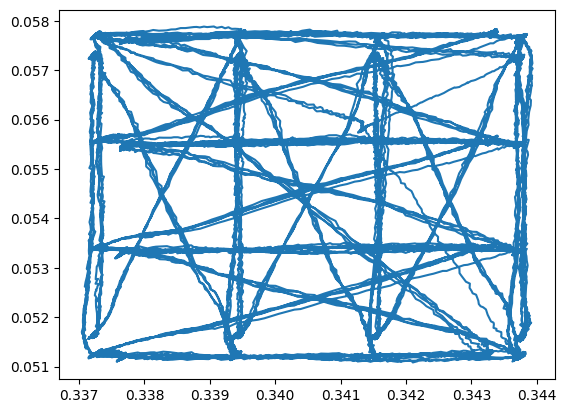

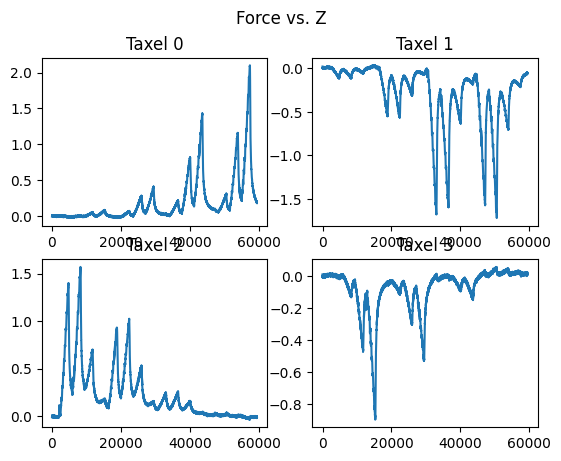

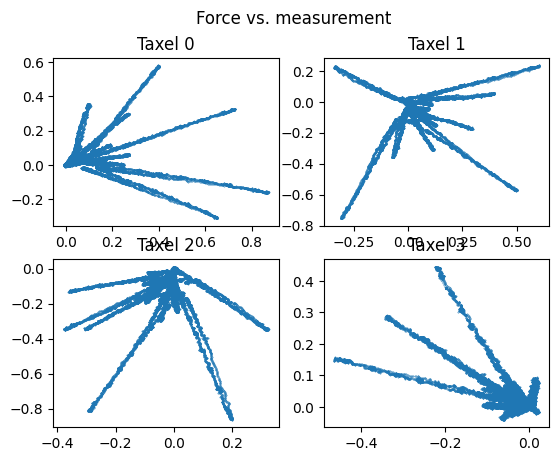

In [7]:
data = all_data_transformed[0]
min_index = 0
max_index = z_calibration_indices[5]
# Plot the forces
plt.plot(data['F_x'].to_numpy()[min_index:max_index], markersize=1)
plt.plot(data['F_y'].to_numpy()[min_index:max_index], markersize=1)
plt.plot(data['F_z'].to_numpy()[min_index:max_index], markersize=1)

plt.show()

plt.plot(data['X'], data['Y'])

# Plot inputs (2x2 subplots)
fig, axs = plt.subplots(ARRAY_H, ARRAY_W)
fig.suptitle('Force vs. Z')
for i in range(ARRAY_SIZE):
    ax = axs[i // ARRAY_W, i % ARRAY_W]
    ax.plot(data[f'Z{i}'].to_numpy()[:max_index])
    ax.set_title(f"Taxel {i}")
plt.show()

fig, axs = plt.subplots(ARRAY_H, ARRAY_W)
fig.suptitle('Force vs. measurement')
for i in range(ARRAY_SIZE):
    ax = axs[i // ARRAY_W, i % ARRAY_W]
    ax.scatter(data[f'X{i}'].to_numpy()[:max_index], data[f'Y{i}'].to_numpy()[:max_index], s=0.1)
    ax.set_title(f"Taxel {i}")
plt.show()

Taxel 0


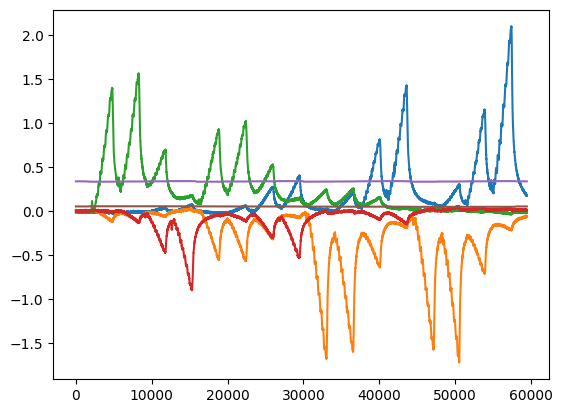

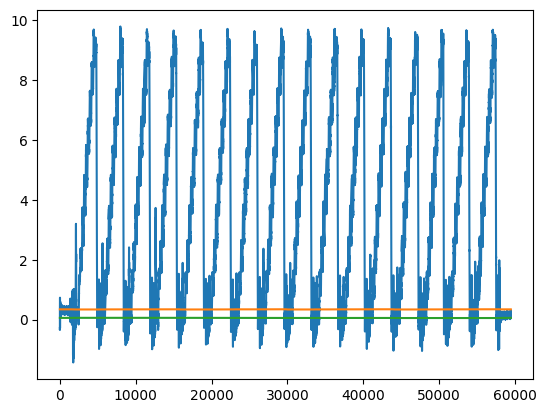

Score:  0.7685518478858849
MSE:  0.9792618524070043
Taxel 1
Score:  0.7658978601783554
MSE:  0.9555205837824121
Taxel 2
Score:  0.7678841778109002
MSE:  0.9858162120130007
Taxel 3


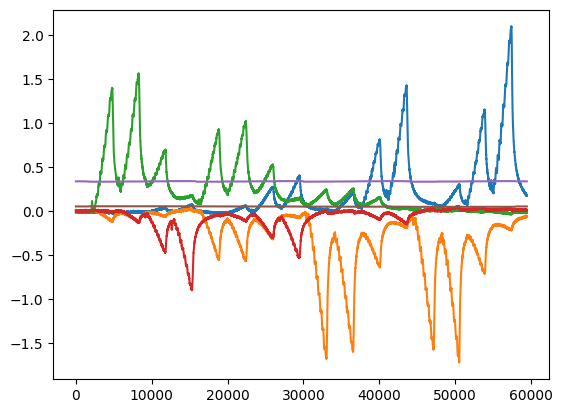

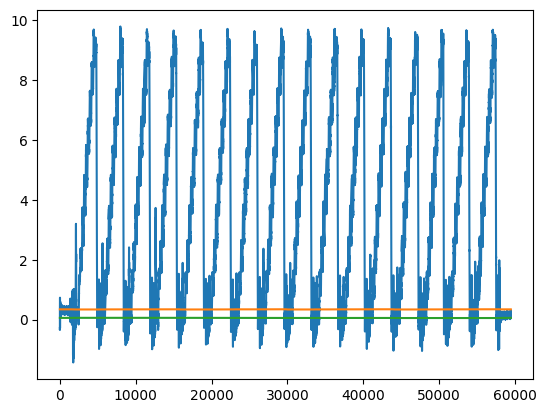

Score:  0.7671118239235438
MSE:  0.9817298354983309
Taxel 4
Score:  0.7645293334836584
MSE:  0.979096175946596
Taxel 5
Score:  0.7679977029596996
MSE:  0.9815498151152574
Taxel 6
Score:  0.7706010277874054
MSE:  0.9648583181925375
Taxel 7
Score:  0.771719680022411
MSE:  0.9426621814885051
Taxel 8
Score:  0.7668890020015119
MSE:  0.9795784423380623
Taxel 9
Score:  0.7664412384689211
MSE:  0.9475671342245545
Taxel 10
Score:  0.7703023977120407
MSE:  0.9657507090118099
Taxel 11
Score:  0.770897992792949
MSE:  0.9688271142768924
Taxel 12


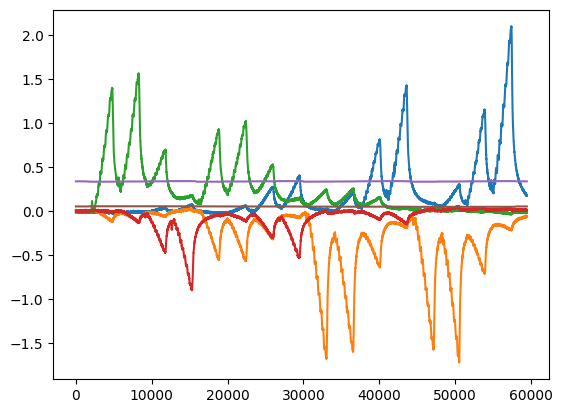

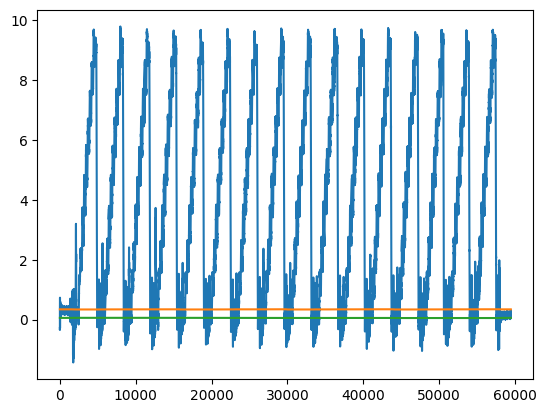

Score:  0.7735546307485897
MSE:  0.9435477134189564
Taxel 13
Score:  0.7685957263382203
MSE:  0.9783267885606586
Taxel 14
Score:  0.766485180320864
MSE:  0.9766157557309542
Taxel 15


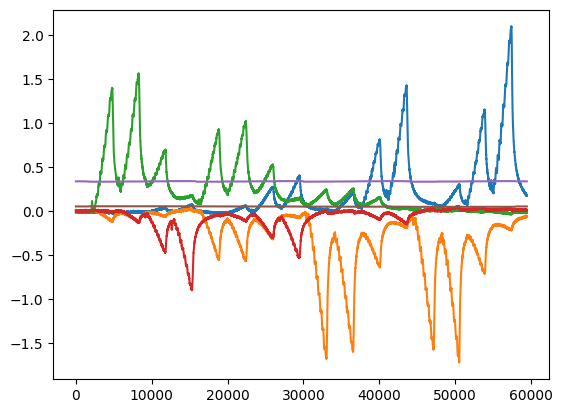

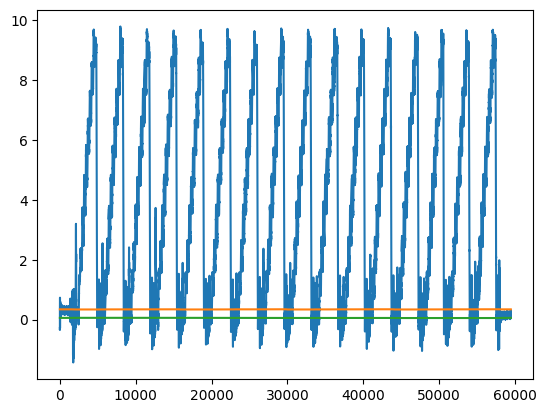

Score:  0.7721220016571761
MSE:  0.9518385521528758


In [8]:

z_taxel_models = []

for i in range(ARRAY_SIZE_SUB):
    
    index = z_calibration_indices[i]
        
    print(f"Taxel {i}")

    data = all_data_transformed[i]
    
    # Replace nan by zero
    data = data.fillna(0)
    
    X = data[[f'Z{k}' for k in range(ARRAY_SIZE)] + ['X', 'Y']].to_numpy()[:index]
    Y = data[['F_z', 'X', 'Y']].to_numpy()[:index]
    
    if i == 0 or i == 3 or i == 12 or i == 15:
        plt.plot(X)
        plt.show()
        
        plt.plot(Y)
        plt.show()
    
    component_model = create_regression_pipeline_and_fit(X, Y, preserve_time=False, alpha=1)
    z_taxel_models.append(component_model)

In [9]:
save_taxel_models(z_taxel_models, F'PolyLinear-Deg{POLY_DEGREE}', MODEL_NAME_Z)
print(data_points)

[[0.33728042 0.05773226]
 [0.33944982 0.05771756]
 [0.34161673 0.05770034]
 [0.34378087 0.05768131]
 [0.33726447 0.05556711]
 [0.33943219 0.0555493 ]
 [0.34159989 0.0555349 ]
 [0.34376498 0.05551504]
 [0.33724925 0.05340412]
 [0.33941416 0.05338495]
 [0.34158036 0.05336572]
 [0.34374801 0.0533503 ]
 [0.33723094 0.0512359 ]
 [0.33939674 0.05121703]
 [0.34156259 0.05119911]
 [0.34372775 0.05118098]]


/home/lowiek/.local/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


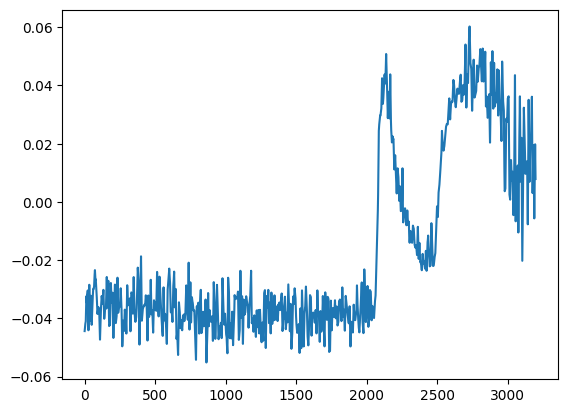

In [277]:

plt.plot(z_taxel_models[3].predict(all_data_transformed[0][[f'Z{k}' for k in range(ARRAY_SIZE)]][:3200]))


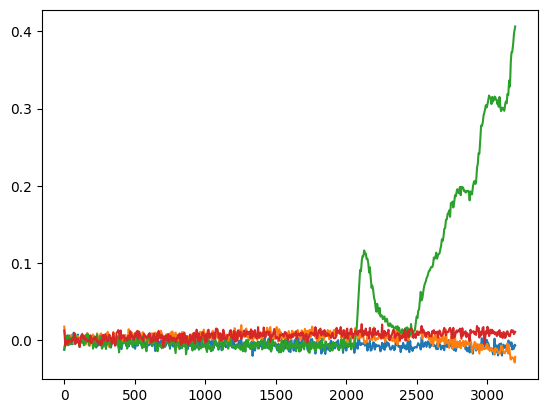

In [278]:
plt.plot(all_data_transformed[15][[f'Z{k}' for k in range(ARRAY_SIZE)]][:3200])

In [280]:

xy_taxel_models = []

for j in range(ARRAY_SIZE_SUB):

    data = all_data_transformed[j]

    #replace nan by zero
    data = data.fillna(0)

    print(f"\nTaxel {j}")
    
    X = data[[f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]][z_calibration_indices[j]:].to_numpy()
    Y = data[[f'F_x', f'F_y']][z_calibration_indices[j]:].to_numpy()

    model = create_regression_pipeline_and_fit(X, Y)
    
    xy_taxel_models.append(model)


Taxel 0
Score:  0.7725264212363556
MSE:  0.027785860717627554

Taxel 1
Score:  0.6014076840012684
MSE:  0.04566517803497345

Taxel 2
Score:  0.5379127023719084
MSE:  0.04681077447686942

Taxel 3


KeyboardInterrupt: 

In [137]:
save_taxel_models(xy_taxel_models, F'PolyLinear-Deg{POLY_DEGREE}', MODEL_NAME_XY)

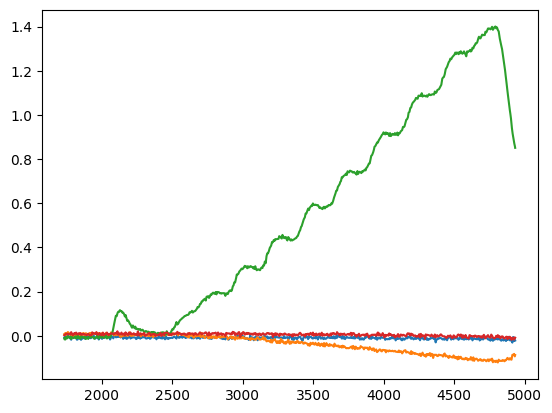

In [141]:
data = all_data_transformed[0][:3200]
plt.plot(data['Z0'])
plt.plot(data['Z1'])
plt.plot(data['Z2'])
plt.plot(data['Z3'])
plt.show()

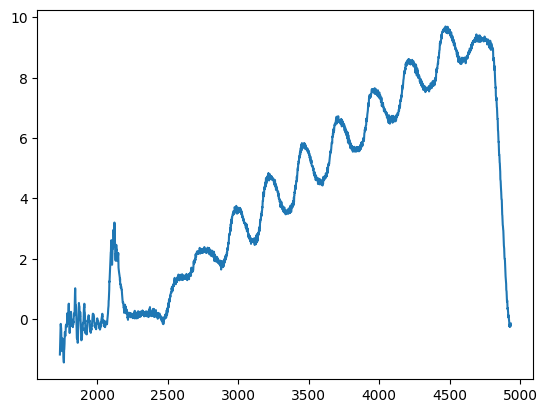

In [143]:
# plt.plot(data['F_z0'])
# plt.plot(data['F_z1'])
# plt.plot(data['F_z2'])
# plt.plot(data['F_z3'])
plt.plot(data['F_z'])
plt.show()